# _Python for Scientific Data Analysis_


#  AstroPy and AstroQuery

## Section 5: Time Series Analysis

(note a lot of this will follow the AstroPy documentation ... which is pretty good)


(Signals from) Things in nature change.  If we take repeat measurements of a given observable over some length of time, a careful analysis of these measurements may reveal periodic signals.   This type of analysis takes on many forms in astronomy (and in other fields): e.g.  the brightness of a star or a spectral feature, the position of a spectral line, etc.   

From sampling a continuous variable at fixed times to counting events binned into time windows, many different areas of astrophysics require the manipulation of 1D time series data. The ``astropy.timeseries`` subpackage provides classes to represent and manipulate time series.  

We will work through several examples of Time Series analysis within AstroPy, first using a simple discrete Fourier Transform (requires even time sampling), then a Box Least Squares algorithm (applicable for detecting transit signals), then a Lomb-Scargle Algorithm (which does not require even time sampling).

In [12]:
import numpy as np
import matplotlib.pyplot as plt

### Fourier Analysis to Identify Periodic Signals

#### A Simple Contrived Example

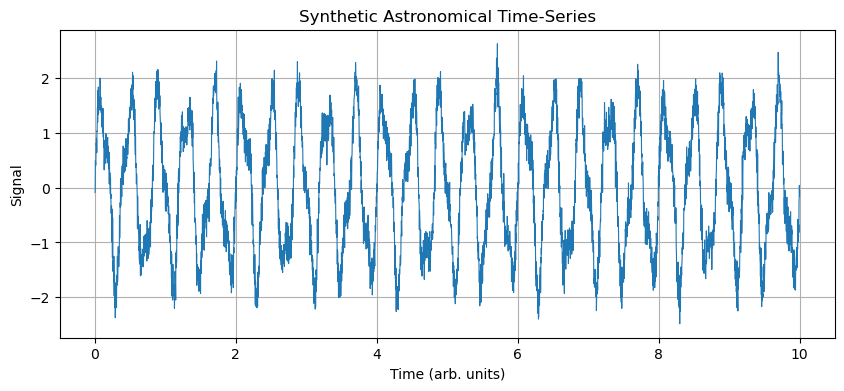

In [34]:
# Simulation parameters
t = np.linspace(0, 10, 4000)  # time from 0 to 10 (arbitrary units), 4000 evenly spaced samples
#a1, f1 = 1.0, 2.5   # amplitude and frequency (Hz or cycles per unit time)
#a2, f2 = 0.5, 7.0   # second sinusoid

a1, f1 = 1.5, 2.5   # amplitude and frequency (Hz or cycles per unit time)
a2, f2 = 0.5, 6.0   # second sinusoid

# Generate the signal: two sinusoids + Gaussian noise
signal = a1 * np.sin(2 * np.pi * f1 * t) + a2 * np.sin(2 * np.pi * f2 * t) + 0.2 * np.random.randn(len(t))

# Plot the synthetic time-series
#plt.figure(figsize=(10, 4))
fig,ax=plt.subplots(figsize=(10,4))
ax.plot(t, signal, lw=0.8)
ax.set_xlabel('Time (arb. units)')
ax.set_ylabel('Signal')
ax.set_title('Synthetic Astronomical Time-Series')
ax.grid(True)
plt.show()

#### _Discrete Fourier Transform_ and _Power Spectrum_
Compute the Discrete Fourier Transform (DFT) of the signal using NumPy's FFT routines, and plot the power spectrum.

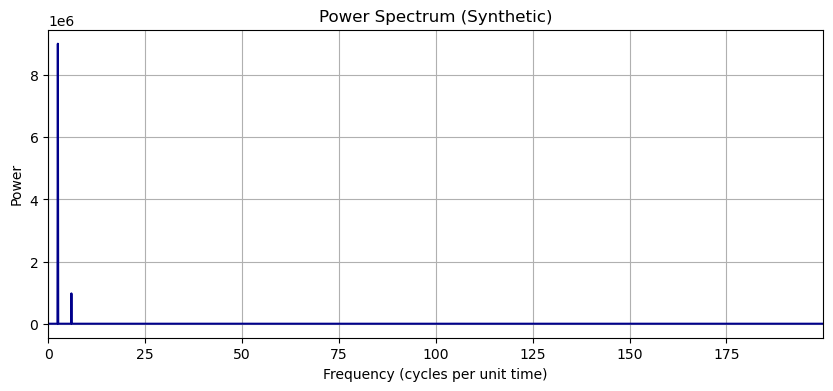

In [36]:
# Compute DFT via FFT

#computes the one-dimensional discrete Fourier Transform (DFT) for real input using the Fast Fourier Transform (FFT)
fft_vals = np.fft.rfft(signal)
dt = t[1] - t[0]  # sampling interval

#returns the DFT sample frequencies 
frequencies = np.fft.rfftfreq(len(t), d=dt)

# Compute power spectrum
power = np.abs(fft_vals)**2

# Plot power spectrum
fig,ax=plt.subplots(figsize=(10,4))
ax.plot(frequencies, power, color='darkblue')
ax.set_xlabel('Frequency (cycles per unit time)')
ax.set_ylabel('Power')
ax.set_title('Power Spectrum (Synthetic)')
ax.grid(True)
ax.set_xlim(0, max(frequencies))
plt.show()

#### _Identify Prominent Frequencies_
We'll pick a few of the largest peaks in the power spectrum and report their frequencies.

In [15]:
# Find peaks

#1) argsort sorts from smallest to largest, [-5:] selects the 5 peaks at the end (i.e. the 5 with the largest power),
#[::-1] reverses the order to so that the last element -- i.e. one with largest power --- is first

peak_indices = np.argsort(power)[-5:][::-1] # top 5 peaks
for idx in peak_indices:
 print(r'Frequency: {0:.4f} | Power: {1:.3f}'.format(frequencies[idx], power[idx]))

#note: that if the time series has a non-zero mean, then the fourier transform of that could create a strong peak at frequency = 0

Frequency: 2.4994 | Power: 8977591.804
Frequency: 5.9985 | Power: 977467.713
Frequency: 110.4724 | Power: 1288.523
Frequency: 2.2994 | Power: 1141.776
Frequency: 180.6548 | Power: 1084.686


Great, so we have recovered the periodic signals at frequencies of 2.5 and 6.0 cycles/time.

## Box Least Squares Algorithm

The “box least squares” (BLS) periodogram [1] is a statistical tool used for detecting transiting exoplanets and eclipsing binaries in time series photometric data. The main interface to this implementation is the BoxLeastSquares class.


The BLS method finds transit candidates by modeling a transit as a periodic upside down top hat with four parameters: period, duration, depth, and a reference time. In this implementation, the reference time is chosen to be the mid-transit time of the first transit in the observational baseline. These parameters are shown in the following sketch:

 ![](./code/sect5/bls-1.png)

 

Assuming that the uncertainties on the measured flux are known, independent, and Gaussian, the maximum likelihood in-transit flux can be computed as 
$\frac{\sum_{in}^{} y_{n}/\sigma_{n}^2}{ 1/\sigma_{n}^2}$
where $y_{n}$ is the flux measurement and $\sigma_{n}$ is the uncertainty in that measurement.

For out of transit, the maximum likelihood flux is:
$\frac{\sum_{out}^{} y_{n}/\sigma_{n}^2}{ 1/\sigma_{n}^2}$

 Using these results, the log likelihood of a transit model (maximized over depth) at a given period $P$
, duration $\tau$
, and reference time $t_{o}$ 
is

$$log(\mathcal{L}(P, \tau, t_{o})) \propto -\frac{1}{2} ( \sum_{in}^{}{(\frac{y_{n}-y_{in}}{ \sigma_n})^{2}} + \sum_{out}^{}{(\frac{y_{n}-y_{out}}{ \sigma_n})^{2}}) $$


Finding the maximum likelihood value is achieved by running over a grid in duration and reference time as specified by the durations and oversample parameters for the ``power`` method.

To demonstrate the Box Least Squares fit we retrieve a FITS file containing a Kepler light curve for a source.  This light curve monitors the brightness of a star.   If a planet is passing in front of the star (i.e. if it is 'transiting' the star) then there will be a brief period of time where the star's brightness will dim by a fraction of a percent.

In [16]:
from astropy.utils.data import get_pkg_data_filename
filename = get_pkg_data_filename('timeseries/kplr010666592-2009131110544_slc.fits')

We can then use the TimeSeries class to read in this file:

In [17]:
from astropy.timeseries import TimeSeries
ts = TimeSeries.read(filename, format='kepler.fits')
ts

time,timecorr,cadenceno,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,sap_quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,d,,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float32,int32,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
2009-05-02T00:41:40.338,6.630610e-04,5500,1.0270451e+06,1.4041933e+02,3.7480554e+03,2.2283568e+00,1.0346376e+06,2.4780812e+02,0,nan,nan,nan,nan,1041.56040,1.3623475e-04,613.47997,1.7336856e-04,1.5822421e-03,-1.4463664e-03
2009-05-02T00:42:39.188,6.630857e-04,5501,1.0271844e+06,1.4042902e+02,3.7491572e+03,2.2283657e+00,1.0347789e+06,2.4594159e+02,0,nan,nan,nan,nan,1041.55834,1.3624557e-04,613.48164,1.7334183e-04,1.5743829e-03,-1.4540013e-03
2009-05-02T00:43:38.045,6.631103e-04,5502,1.0270762e+06,1.4038968e+02,3.7502588e+03,2.2283745e+00,1.0346701e+06,2.4408449e+02,0,nan,nan,nan,nan,1041.55751,1.3616899e-04,613.47866,1.7328140e-04,1.5665225e-03,-1.4616371e-03
2009-05-02T00:44:36.894,6.631350e-04,5503,1.0271414e+06,1.4042482e+02,3.7513606e+03,2.2283831e+00,1.0347365e+06,2.4229922e+02,0,nan,nan,nan,nan,1041.55898,1.3622017e-04,613.47947,1.7331526e-04,1.5586632e-03,-1.4692718e-03
2009-05-02T00:45:35.752,6.631597e-04,5504,1.0271569e+06,1.4039404e+02,3.7524626e+03,2.2283916e+00,1.0347527e+06,2.4051416e+02,0,nan,nan,nan,nan,1041.55705,1.3621294e-04,613.48085,1.7329821e-04,1.5508028e-03,-1.4769078e-03
2009-05-02T00:46:34.601,6.631844e-04,5505,1.0272296e+06,1.4043083e+02,3.7535642e+03,2.2284005e+00,1.0348268e+06,2.3879796e+02,0,nan,nan,nan,nan,1041.55916,1.3619773e-04,613.47844,1.7329390e-04,1.5429436e-03,-1.4845425e-03
2009-05-02T00:47:33.451,6.632091e-04,5506,1.0273199e+06,1.4040657e+02,3.7546660e+03,2.2284091e+00,1.0349186e+06,2.3708369e+02,0,nan,nan,nan,nan,1041.55680,1.3621902e-04,613.47908,1.7324935e-04,1.5350844e-03,-1.4921773e-03
2009-05-02T00:48:32.291,6.632337e-04,5507,1.0271497e+06,1.4042722e+02,3.7557673e+03,2.2284179e+00,1.0347472e+06,2.3542677e+02,0,nan,nan,nan,nan,1041.55869,1.3619712e-04,613.47893,1.7332737e-04,1.5272264e-03,-1.4998110e-03


In [18]:
ts['sap_flux']
ts['time', 'sap_flux']

#TimeSeries objects have a time column, which is always the first column. This column can also be accessed using the .time attribute:
#ts.time

time,sap_flux
,electron / s
Time,float32
2009-05-02T00:41:40.338,1.0270451e+06
2009-05-02T00:42:39.188,1.0271844e+06
2009-05-02T00:43:38.045,1.0270762e+06
2009-05-02T00:44:36.894,1.0271414e+06
2009-05-02T00:45:35.752,1.0271569e+06
2009-05-02T00:46:34.601,1.0272296e+06
2009-05-02T00:47:33.451,1.0273199e+06
2009-05-02T00:48:32.291,1.0271497e+06


In [19]:
#convert to Modified Julian Date (MJD)
ts.time.mjd

array([54953.0289391 , 54953.02962023, 54953.03030145, ...,
       54962.7536398 , 54962.75432093, 54962.75500215])

[Text(0.5, 0, 'Modified Julian Date'), Text(0, 0.5, 'SAP Flux (e-/s)')]

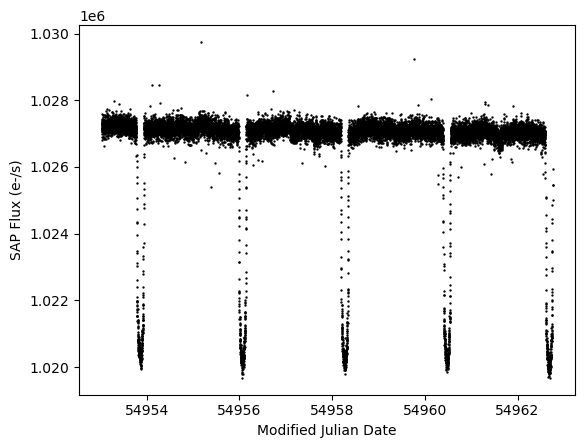

In [20]:
#now to plot ...
from matplotlib.ticker import FormatStrFormatter
fig, ax = plt.subplots()
#ax.scatter(ts.time.jd-2400000.5, ts['sap_flux'], color='black', marker='o',s=0.5)
ax.scatter(ts.time.mjd, ts['sap_flux'], color='black', marker='o',s=0.5)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.set(xlabel='Modified Julian Date', ylabel='SAP Flux (e-/s)')

We can use the BoxLeastSquares class to estimate the period, using the “box least squares” (BLS) algorithm:

In [21]:
from astropy import units as u
from astropy.timeseries import BoxLeastSquares

In [22]:
periodogram = BoxLeastSquares.from_timeseries(ts, 'sap_flux')

#periodogram = BoxLeastSquares.from_timeseries(ts, 'sap_flux')
#results = periodogram.autopower(0.2 * u.day)
results = periodogram.autopower(0.2 * u.day)
#periodogram = model.autopower(0.2)
results.period

<Quantity [0.4       , 0.40033857, 0.40067771, ..., 4.75579216, 4.80409697,
           4.85339313] d>

best fitting results
period of the transit 2.205517 d
transit time 2009-05-02T20:51:16.338


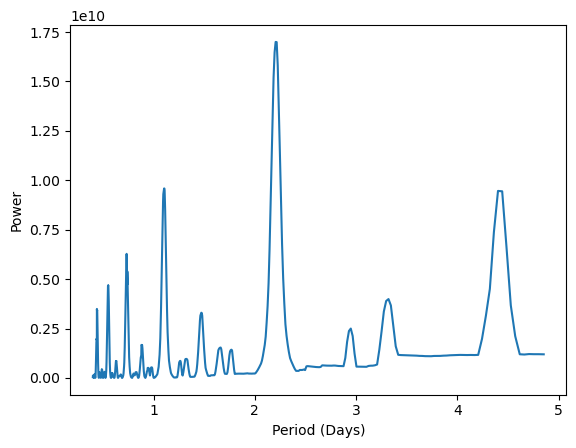

In [23]:
fig,ax=plt.subplots()
ax.plot(results.period, results.power)
ax.set_xlabel('Period (Days)')
ax.set_ylabel('Power')

best = np.argmax(results.power) #find the periodic signal with the maximum power
print('best fitting results')
period_transit = results.period[best]
transit_time = results.transit_time[best]
print('period of the transit {0:f}'.format(period_transit))
print('transit time {0:s}'.format(transit_time.value))

In [24]:
#phase fold the data

ts_folded = ts.fold(period=period_transit, epoch_time=transit_time)

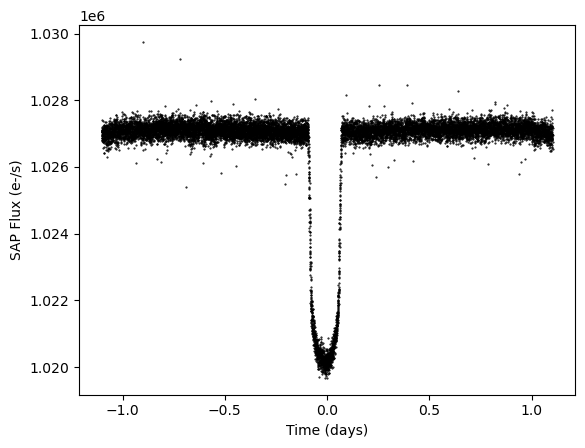

In [25]:
fig, ax = plt.subplots()
ax.plot(ts_folded.time.jd, ts_folded['sap_flux'], 'k.', markersize=1)
ax.set(xlabel='Time (days)', ylabel='SAP Flux (e-/s)')
plt.show()

In [26]:
from astropy.stats import sigma_clipped_stats
mean, median, stddev = sigma_clipped_stats(ts_folded['sap_flux'])
ts_folded['sap_flux_norm'] = ts_folded['sap_flux'] / median

[Text(0.5, 0, 'Time (days)'), Text(0, 0.5, 'Normalized flux')]

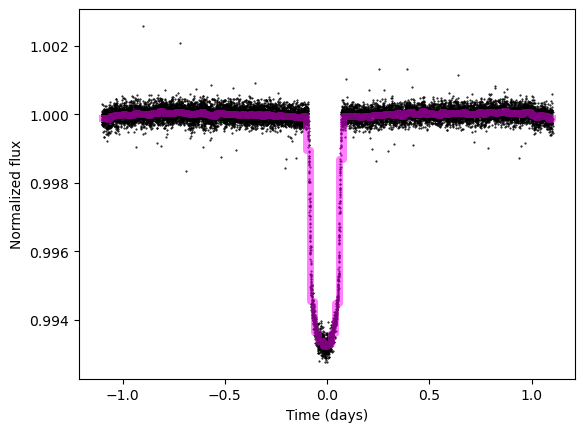

In [27]:
from astropy.timeseries import aggregate_downsample
ts_binned = aggregate_downsample(ts_folded, time_bin_size=0.02 * u.day)

fig, ax = plt.subplots()
ax.plot(ts_folded.time.jd, ts_folded['sap_flux_norm'], 'k.', markersize=1)
ax.plot(ts_binned.time_bin_start.jd, ts_binned['sap_flux_norm'], color='magenta',lw=5,alpha=0.5, drawstyle='steps-post')
ax.set(xlabel='Time (days)', ylabel='Normalized flux')


## Lomb-Scargle Periodigram Algorithm

The Lomb–Scargle (LS) periodogram is a well known, widely-used algorithm for detecting and characterizing periodic signals in unevenly sampled data.  It is equivalent to fitting a sine wave of the form $y(t)=a\cos (\omega t)+b\sin (\omega t)$ to the data using a least-squares approach, at each given frequency ($\omega = 2\pi f$).  The mathematical form describing the power as a function of angular frequency $\omega$ is:

$$
P_{\text{LS}}(\omega) = \frac{1}{2\sigma^2} \left( \frac{\left[ \sum_{i=1}^N (y_i - \bar{y}) \cos\omega(t_i - \tau) \right]^2}{\sum_{i=1}^N \cos^2\omega(t_i - \tau)} + \frac{\left[ \sum_{i=1}^N (y_i - \bar{y}) \sin\omega(t_i - \tau) \right]^2}{\sum_{i=1}^N \sin^2\omega(t_i - \tau)} \right)
$$

where:

* $\omega = 2\pi f$ is the angular frequency.
* $\bar{y} = \frac{1}{N} \sum_{i=1}^N y_i$ is the mean of the data.
* $\sigma^2 = \frac{1}{N-1} \sum_{i=1}^N (y_i - \bar{y})^2$ is the variance of the data.
* $\tau$ is a time offset defined to make the periodogram time-invariant and ensure statistical properties, which is calculated at each frequency $\omega$ by:


$$
\tan(2\omega\tau) = \frac{\sum_{i=1}^N \sin(2\omega t_i)}{\sum_{i=1}^N \cos(2\omega t_i)}
$$

Note: In standard linear regression problems, if your basis functions (in this case, $\cos (\omega (t_{i}-\tau ))$ and $\sin (\omega (t_{i}-\tau ))$ are orthogonal, the calculation of the coefficients (a and b) becomes much simpler. Without $\tau$ (non-orthogonal): The normal equations for the least-squares fit involve solving a 2x2 matrix inversion at every single frequency. This is computationally expensive.  With $\tau$ (orthogonal), the dot product of the basis functions (cos and sine terms) is zero, so the solutions to a and b are independent (there is no covariance between them).

#### _Advantage of the LS periodigram_
The LS periodogram works for unevenly sampled data, unlike the standard Discrete Fourier Transform (DFT), which assumes uniform sampling.

In [28]:
from astropy.timeseries import LombScargle

In [29]:

###SIMPLE EXAMPLE
# Simulate RV data
np.random.seed(42)
N = 100
times = np.sort(150 * np.random.rand(N))
true_period = 20.0
omega = 2 * np.pi / true_period
K = 10.0
rv = K * np.sin(omega * times) + np.random.normal(0, 2, N)

# Lomb-Scargle
frequency, power = LombScargle(times, rv).autopower()
period = 1 / frequency

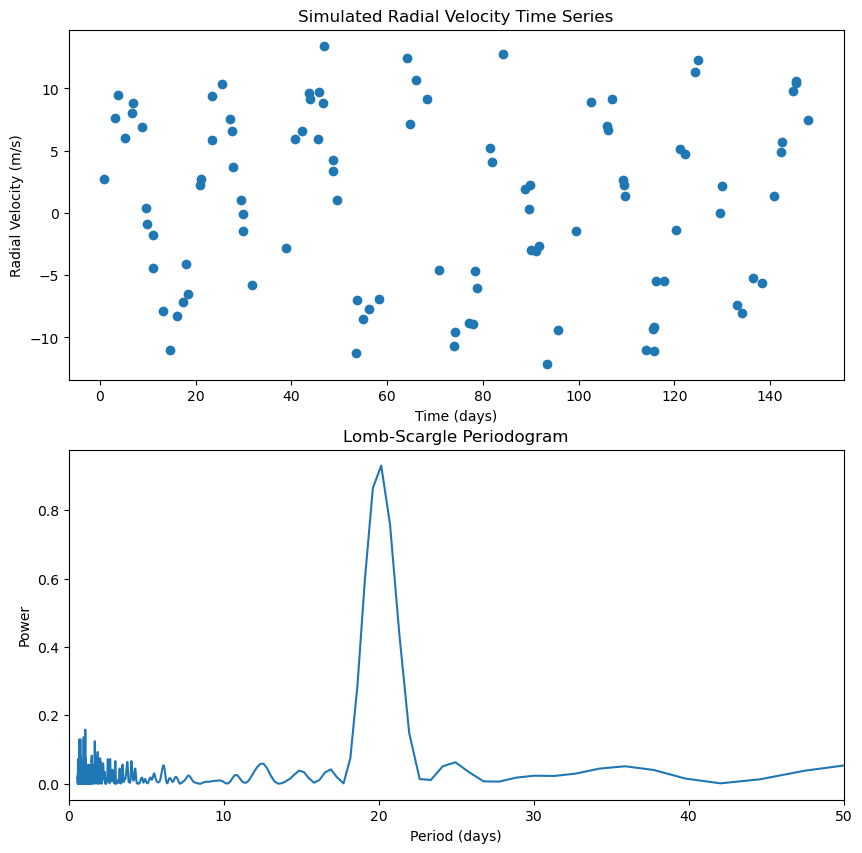

In [30]:
# Plot RV time series
fig,ax=plt.subplots(2,1,figsize=(10,10))
ax[0].scatter(times, rv)
ax[0].set_xlabel("Time (days)")
ax[0].set_ylabel("Radial Velocity (m/s)")
ax[0].set_title("Simulated Radial Velocity Time Series")


# Plot periodogram


ax[1].plot(period, power)
ax[1].set_xlim(0, 50)
ax[1].set_xlabel("Period (days)")
ax[1].set_ylabel("Power")
ax[1].set_title("Lomb-Scargle Periodogram")
plt.show()

In [31]:
### 2 - Multiple real peaks

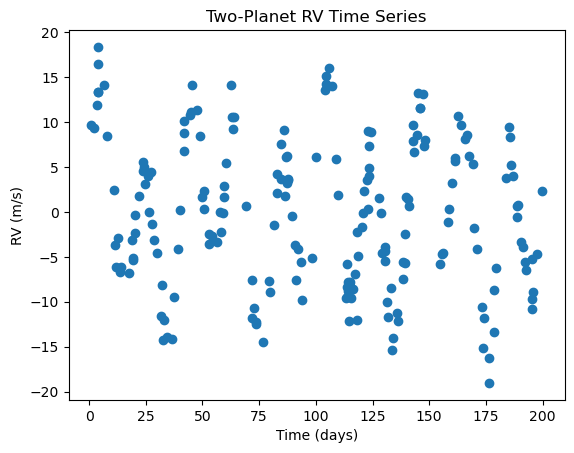

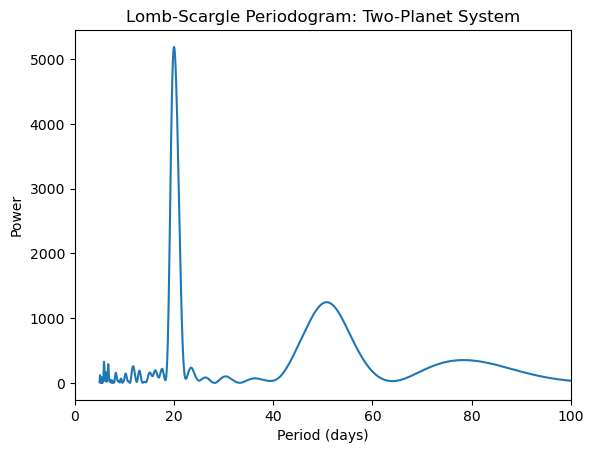

In [32]:
# Multiple-planet radial velocity simulation and Lomb-Scargle analysis

from scipy.signal import lombscargle

# Simulated two-planet system
np.random.seed(0)
N = 200
times = np.sort(200 * np.random.rand(N))

# Planet parameters
P1, K1 = 20.0, 10.0  # first planet
P2, K2 = 50.0, 5.0   # second planet

rv = (
    K1 * np.sin(2 * np.pi * times / P1)
    + K2 * np.sin(2 * np.pi * times / P2 + 1.0)
    + np.random.normal(0, 2, N)
)

# Frequencies for periodogram
freqs = np.linspace(0.01, 0.2, 20000)
power = lombscargle(times, rv, 2 * np.pi * freqs)
periods = 1 / freqs

# Plot time series
plt.figure(); plt.scatter(times, rv)
plt.xlabel("Time (days)"); plt.ylabel("RV (m/s)"); plt.title("Two-Planet RV Time Series")
plt.show()

# Plot Lomb-Scargle periodogram
plt.figure(); plt.plot(periods, power)
plt.xlim(0, 100)
plt.xlabel("Period (days)"); plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram: Two-Planet System")
plt.show()


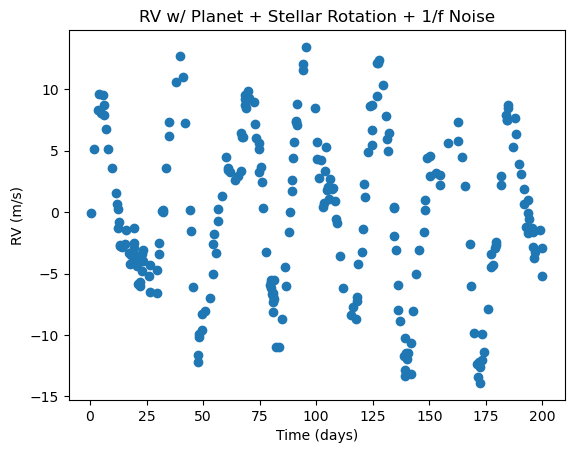

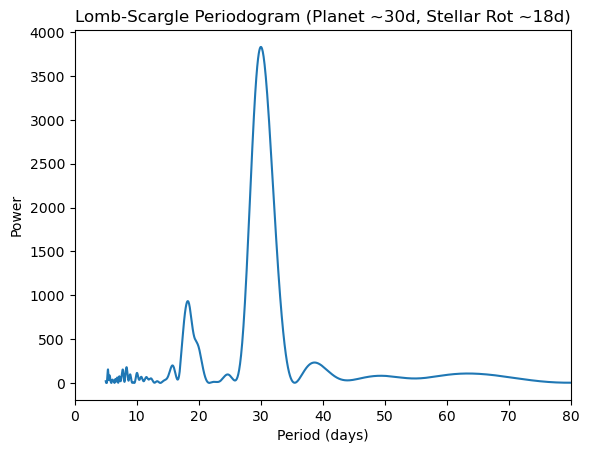

In [33]:
# #### 3 with stellar activity noise

# RV time series with stellar rotation + 1/f granulation noise

from scipy.signal import lombscargle

# Time sampling
time_span = 200
N = 250
times = np.sort(time_span * np.random.rand(N))

# Planet parameters
P_planet = 30.0
K_planet = 8.0
planet_rv = K_planet * np.sin(2 * np.pi * times / P_planet)

# Stellar rotation signal
P_rot = 18.0
K_rot = 4.0
stellar_rot = K_rot * np.sin(2 * np.pi * times / P_rot + 0.5)

# Granulation / 1/f noise
#A ``1/f`` power law means lower frequencies have higher power (more variability), consistent with granulation / stellar activity noise.
freqs_noise = np.fft.rfftfreq(N, d=(time_span/N))

#``np.maximum(freqs_noise, 0.01)`` prevents division by zero at frequency = 0 and avoids infinite power at the lowest bin.
#So frequencies < 0.01 are clamped to 0.01.

power_spectrum = 1/np.maximum(freqs_noise,0.01)

#Creates complex Gaussian noise in the frequency domain (random amplitude + phase).


noise_ft = (np.random.normal(size=len(freqs_noise)) + 1j*np.random.normal(size=len(freqs_noise))) * np.sqrt(power_spectrum)

#1j creates an imaginary component → needed for inverse FFT; Multiply by sqrt(power_spectrum) because:
#Power spectrum ∝ amplitude² So amplitude scales as √power
#This line ensures the noise has the prescribed 1/f spectral shape — meaning it has more low-frequency power than high-frequency.


#Inverse Fourier Transform to convert back to time domain
noise = np.fft.irfft(noise_ft)
noise = noise / np.std(noise) * 2  # scale to ~2 m/s

# Combined RV
total_rv = planet_rv + stellar_rot + noise

# Lomb-Scargle
freqs = np.linspace(0.01, 0.2, 30000)
power = lombscargle(times, total_rv, 2 * np.pi * freqs)
periods = 1 / freqs

# Time series plot
plt.figure(); plt.scatter(times, total_rv)
plt.xlabel("Time (days)"); plt.ylabel("RV (m/s)")
plt.title("RV w/ Planet + Stellar Rotation + 1/f Noise")
plt.show()

# Periodogram
plt.figure(); plt.plot(periods, power)
plt.xlim(0, 80)
plt.xlabel("Period (days)"); plt.ylabel("Power")
pks = "Planet ~30d, Stellar Rot ~18d"
plt.title(f"Lomb-Scargle Periodogram ({pks})")
plt.show()